In [1]:
using Revise

In [3]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaF_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **



## Define CaOH Hamiltonian and molecular states

In [4]:
package = get_CaF_package() # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_CaF_package_12_A_states() # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m
λ = 2π / k

# add a 4.8 MHz hyperfine splitting in the A state
package.states[14].E += 4.8e6
package.states[15].E += 4.8e6
package.states[16].E += 4.8e6
;

## Define experimental parameters

In [125]:
## Initial condition of the molecule cloud
temp = @with_unit 100 "μK"
diameter = @with_unit 200 "μm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]

## Laser intensities
Isat = π*h*c*Γ/(3λ^3) / 10

I = 5.8 # mW/cm^2, for each beam
s = I / Isat

# Define B field gradient and ramp time
B_gradient = -78.0
ramp_time = 1e-6

## Laser detunings - optimal so far
detuning = 9.0
δ1 = +0.0
δ2 = +4.0
δ3 = +3.0
δ4 = -0.6
δ5 = +0.6

Δ1 = 1e6 * (detuning + δ1) # addresses F=1-
Δ2 = 1e6 * (detuning + δ2) + (energy(package.states[6]) - energy(package.states[4])) # addresses F=1+, but instead F=0
Δ3 = 1e6 * (detuning + δ3) # addresses F=1+
Δ4 = 1e6 * (detuning + δ4) # addresses F=2
Δ5 = 1e6 * (detuning + δ5) # addresses F=2

s1 = 1.2s
s2 = 0.0s
s3 = 3.0s
s4 = 0.5s
s5 = 0.5s

# # CaF configuration
# B_gradient = -14.6
# ramp_time = 1e-6

# detuning = 23.8
# δ1 = -0.75
# δ2 = +0.0
# δ3 = +0.0
# δ4 = +0.0
# δ5 = +0.0

# Δ1 = 1e6 * (detuning + δ1) # addresses F=1-
# Δ2 = 1e6 * (detuning + δ2)
# Δ3 = 1e6 * (detuning + δ3)
# Δ4 = 1e6 * (detuning + δ4)
# Δ5 = 1e6 * (detuning + δ5) # addresses F=2

# s1 = 1.0 * 1s / (1 + 1.4)
# s2 = 0s
# s3 = 0s
# s4 = 0s
# s5 = 1.4 * 1s / (1 + 1.4)

# # CaF Λ-cooling
# B_gradient = 0.0
# ramp_time = 1e-6

# detuning = 30.0
# δ1 = +2.0
# δ2 = +0.0
# δ3 = +0.0
# δ4 = +0.0
# δ5 = +0.0

# Δ1 = 1e6 * (detuning + δ1) # addresses F=1-
# Δ2 = 1e6 * (detuning + δ2)
# Δ3 = 1e6 * (detuning + δ3)
# Δ4 = 1e6 * (detuning + δ4)
# Δ5 = 1e6 * (detuning + δ5) # addresses F=2

# s1 = 1.00 * 2s / (1.00 + 0.92)
# s2 = 0s
# s3 = 0s
# s4 = 0s
# s5 = 0.92 * 2s / (1.00 + 0.92)

# ## Laser detunings
# detuning = 23.6
# δ1 = +0.0
# δ2 = -4.0
# δ3 = -3.0
# δ4 = +1.0
# δ5 = -1.0

# Δ1 = 1e6 * (detuning + δ1) # addresses F=1-
# Δ2 = 1e6 * (detuning + δ2) #+ (energy(package.states[6]) - energy(package.states[4])) # addresses F=1+, but instead F=0
# Δ3 = 1e6 * (detuning + δ3) # addresses F=1+
# Δ4 = 1e6 * (detuning + δ4) # addresses F=2
# Δ5 = 1e6 * (detuning + δ5) # addresses F=2

# s1 = 1.0s
# s2 = 0.0s
# s3 = 0.0s
# s4 = 1.0s
# s5 = 1.0s

blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 35e-3, n_values = 300,
                                pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁺, pol4_x=σ⁻, pol5_x=σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5=Δ5,

                                B_gradient = B_gradient,
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter,
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 1.0,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2/2,

                                diffusion_constant = 0.0
)
;

## Run fixed timestepping solver

## Find the diffusion constant

In [126]:
results, diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-3, n_particles=20,
                                            ramp_time=1e-6, temp=150e-6, diameter=200e-6, count_last_scatters=200)
@printf("Diffusion constant = %.2f \n", diffusion_constant)

blue_MOT_params.diffusion_constant = diffusion_constant
;

Progress: 100%|█████████████████████████████████████████| Time: 0:14:40


Diffusion constant = 0.02 


In [128]:
blue_MOT_params.diffusion_constant = diffusion_constant

0.021171958926291177

In [129]:
results.sum_diffusion_x ./ results.photons_scattered

20-element Vector{Float64}:
   0.022391189318052472
   0.020158463649176523
   0.02291197587937182
 289.97903699591285
   0.02229362266532137
   0.021217511854204875
   0.0209875956515137
   0.021173814719375468
   0.022801673056704008
   0.022425071186787236
   0.023033660984062773
   0.021465636325248748
   0.021135426815722773
   0.02145035334855219
   0.02092994708450793
   0.02210714282438917
   0.0188657586404566
   0.023577769776893714
   0.018393278818068265
   0.02290781559056641

In [130]:
# blue_MOT_params.diffusion_constant = 0.0
# ;

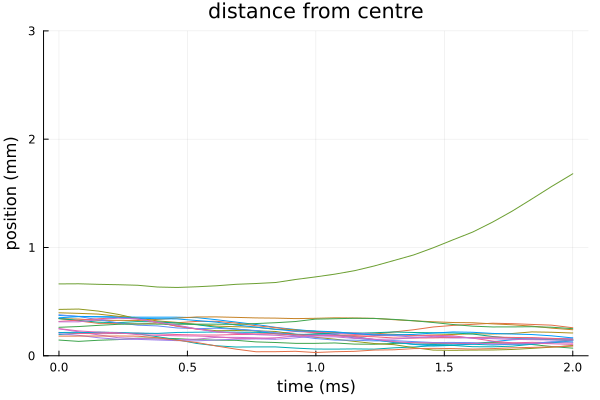

In [131]:
plot_all_trajectories(results, "all")
plot!(ylim=[0,3.0])

## Run a constant-diffusion simulation
Define an experimental sequence. In this example, it's just the blue MOT. But we could also simulate an entire experimental sequence, such as 
red MOT -> lambda cooling -> blue MOT -> single frequency cooling -> ODT loading

In [132]:
sequence = [blue_MOT_params]
durations = [5e-3]
generate_sequence!(sequence, durations)
@time results = simulate_particles_constant_diffusion(package, package_A, sequence)
;

Progress: 100%|█████████████████████████████████████████| Time: 1:37:42m


5862.197124 seconds (737.88 k allocations: 184.828 MiB)


## Plot simulation results

### Plot the molecules' trajectories

Note that molecules that are too far away from the centre are discarded, which is why some trajectories end prematurely.

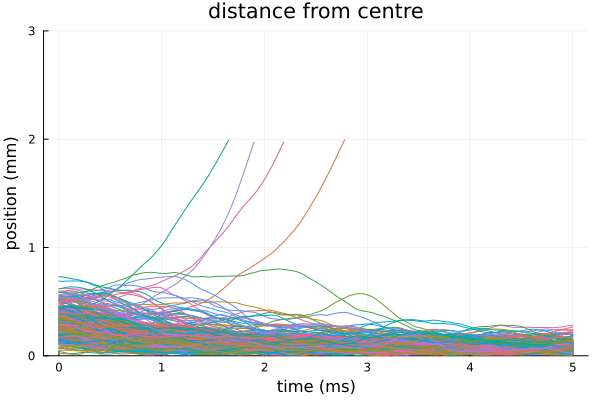

In [133]:
plot_all_trajectories(results, "all")
plot!(ylim=[0,3])

### Plot the cloud size over time 
The size here is obtained from the standard dzviation of the position distribution.
There is also an option to find the final cloud size by fitting to a Gaussian.

Final size = 0.065 mm

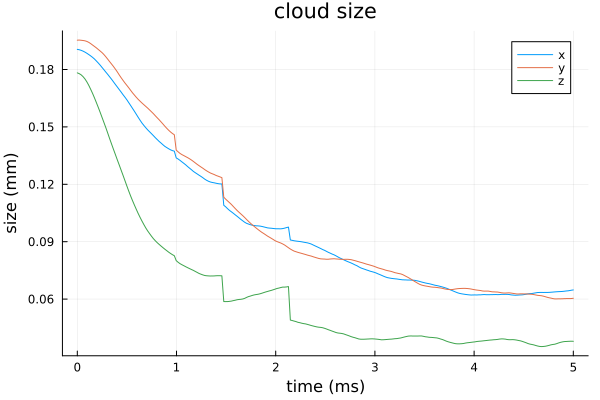

In [134]:
~, σ = plot_size(results, "all")
@printf("Final size = %.3f mm", σ[end])
plot!()

In [135]:
function survived(i, t_end, times)
    return t_end ≈ times[i][end]
end

times = results.times .* 1e-3
t_end = blue_MOT_params.t_end

survived_molecules = [i for i ∈ 1:results.n_values if survived(i, t_end, times)]

survived_times = times[survived_molecules]

survived_x_trajectories = results.x_trajectories[survived_molecules]
survived_y_trajectories = results.y_trajectories[survived_molecules]
survived_z_trajectories = results.z_trajectories[survived_molecules]
survived_x_velocities = results.x_velocities[survived_molecules]
survived_y_velocities = results.y_velocities[survived_molecules]
survived_z_velocities = results.z_velocities[survived_molecules]
;

In [153]:
function cloud_size(time, times, x_trajectories, y_trajectories, z_trajectories)
    xs = []
    ys = []
    zs = []
    for i ∈ eachindex(times)
        time_idx = searchsortedfirst(times[i], time)
        if length(times[i]) > time_idx
            push!(xs, x_trajectories[i][time_idx])
            push!(ys, y_trajectories[i][time_idx])
            push!(zs, z_trajectories[i][time_idx])
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -0.5:0.03:0.5)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [0.3, 0., 5])
    σ, x0, A = v_fit.param
    
    histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return σ
end
;

In [154]:
using StatsBase

In [155]:
xs = [survived_x_trajectories[i][end] for i ∈ 1:length(survived_molecules)]
ys = [survived_y_trajectories[i][end] for i ∈ 1:length(survived_molecules)]
zs = [survived_z_trajectories[i][end] for i ∈ 1:length(survived_molecules)]

hist_data = fit(Histogram, zs, -0.5:0.04:0.5)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs, bins=hist_data.edges, xlim=(-1.0, 1.0), alpha=0.5, normalize=true)

LoadError: BoundsError: attempt to access 296-element Vector{Vector{Float64}} at index [297]

In [156]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_x_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_y_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_z_trajectories]) for i ∈ eachindex(survived_x_trajectories[1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

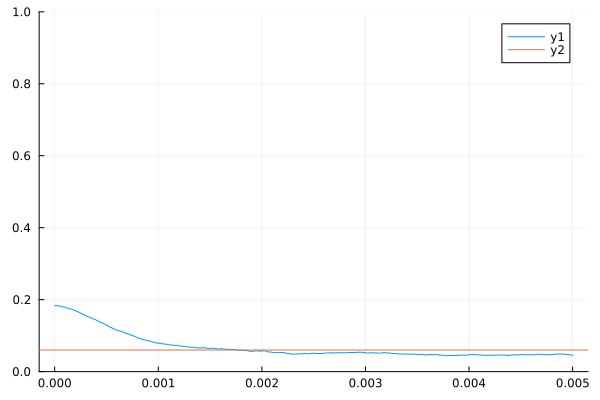

In [158]:
plot(survived_times[1], cloud_sizes_fitted, ylim=(0,1.0))
hline!([0.06])

In [159]:
cloud_sizes_fitted[end-30]

0.04654983987473362

### Plot temperature over time 
Temperatures here are obtained from the standard deviation of the velocity distribution. One could also fit the velocity distribution to a Gaussian.

Temperature = 117.7 uK

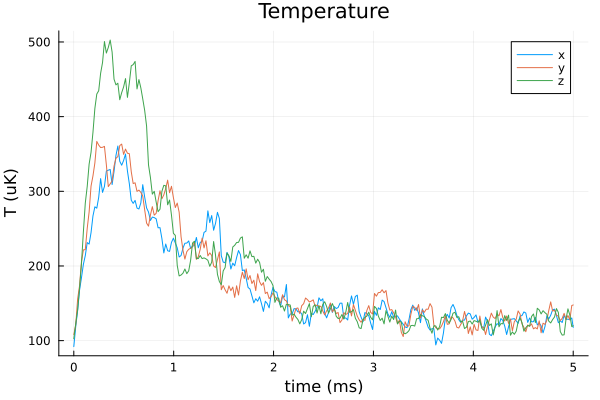

In [149]:
~, T = plot_temperature(results, "all")
@printf("Temperature = %.1f uK", T[end])
plot!()

### Plot the scattering rate of the molecules 
Scattering rate = excited state population * Γ

Average scattering rate = 0.81 MHz

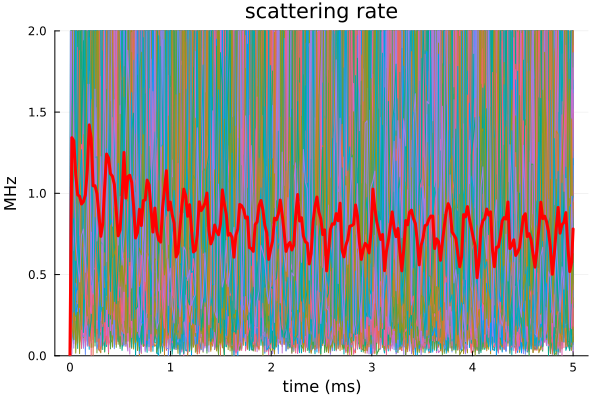

In [150]:
sr = plot_scattering_rate(results)
@printf("Average scattering rate = %.2f MHz", sr)
plot!(ylim=[0,2])

2-element Vector{Float64}:
 0.9394238286051146
 0.00010534919732563838

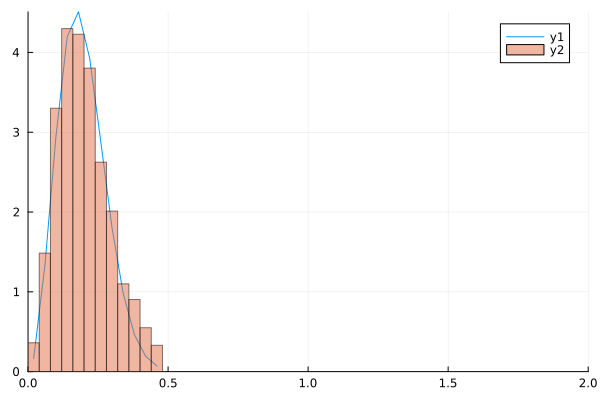

In [151]:
kB = 1.38e-23

survived_molecules = 1:300
velocities = [sqrt.(results.x_velocities[i].^2 .+ results.y_velocities[i].^2 .+ results.z_velocities[i].^2) for i ∈ survived_molecules];

function maxwell_boltzmann(v, p)
    A, T = p
    return A * ((m/(2π*kB*T))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*T)))
end

# take velocities from t = 5 ms to t = 8 ms
vs = [[v[end-10:end] for v ∈ velocities]]
vs = vec(hcat(vs...))
vs = vec(hcat(vs...))
# vs = [[v[end-10] for v ∈ velocities]]
# vs = vec(hcat(vs...))

hist_data = fit(Histogram, vs, 0.0:0.04:0.5)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
A, T = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs, bins=hist_data.edges, xlim=(0.0, 2.0), alpha=0.5, normalize=true)

In [152]:
T * 1e6

105.34919732563839

In [72]:
function fit_temperature(vs)

    hist_data = fit(Histogram, vs, 0.0:0.04:2.0)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
    A, T = v_fit.param
    
    # histogram!(vs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return T
end
;

In [74]:
fit_temperature([v[end] for v ∈ velocities]) * 1e6

40.99011917878049